# Visualizing StackOverflow tags

[StackOverflow](http://stackoverflow.com) is a question-and-answer website for programmers. Each question can have up to 5 descriptive tags for people to be able to find related tags. In this demo, we will look at 50,000 questions with more than 3 tags to try to visualize what StackOverflow is all about. The data came from http://data.stackexchange.com/stackoverflow/query/new with a query like this: 

```
select tags from posts where PostTypeId=1 and tags like '%><%><%'
```

The notebook cells below use `pymldb`'s `Connection` class to make [REST API](/doc/#builtin/WorkingWithRest.md.html) calls. You can check out the [Using `pymldb` Tutorial](/doc/nblink.html#_tutorials/Using pymldb Tutorial) for more details.

In [1]:
from pymldb import Connection
mldb = Connection()

The sequence of procedures below is based on the one explained in the [Mapping Reddit](/doc/nblink.html#_demos/Mapping Reddit) demo notebook. In pseudo-code:

```
dataset so_raw = import("http://opensource.datacratic.com/mldb-demo-resources/stackoverflow.csv.gz")
dataset so_tags = tokenize(so_raw)
dataset so_counts = count(transpose(so_tags))
dataset so_svd_embedding = svd_embed(so_tags)
dataset so_kmeans_clusters = kmeans_cluster(so_svd_embedding)
dataset so_tsne_embedding = tsne_embed(so_svd_embedding)
```

In [2]:
# dataset so_raw = import("http://opensource.datacratic.com/mldb-demo-resources/stackoverflow.csv.gz")
print mldb.v1.datasets("so_raw").put({
    "type": "text.line",
    "params": {
        "dataFileUrl": "http://opensource.datacratic.com/mldb-demo-resources/stackoverflow.csv.gz"
    }
})

# dataset so_tags = tokenize(so_raw)
print mldb.v1.procedures.post({
    "id": "so_import",
    "type": "transform",
    "params": {
        "inputDataset": "so_raw",
        "outputDataset": "so_tags",
        "select": "tokenize(lineText, {splitchars: '\"\r<>', quotechar: ''}) as *",
        "runOnCreation": True
    }
})

# dataset so_counts = count(transpose(so_tags))
print mldb.v1.procedures.post({
    "id": "so_counts",
    "type": "transform",
    "params": {
        "inputDataset": "transpose(so_tags)",
        "outputDataset": "so_counts" ,
        "select": "columnCount() AS numQuestions",
        "rowName": "rowName() + '|1'",
        "runOnCreation": True
    }
})

# dataset so_svd_embedding = svd_embed(so_tags)
print mldb.v1.procedures.post({
    "id": "so_svd",
    "type" : "svd.train",
    "params" : {
        "trainingData" : """
            select 
                COLUMN EXPR (AS columnName() ORDER BY rowCount() DESC, columnName() LIMIT 6000) 
            from so_tags
        """,
        "columnOutputDataset" : "so_svd_embedding",
        "numSingularValues": 100,
        "runOnCreation": True
    }
})

# dataset so_kmeans_clusters = kmeans_cluster(so_svd_embedding)
print mldb.v1.procedures.post({
    "id" : "so_kmeans",
    "type" : "kmeans.train",
    "params" : {
        "trainingData" : "select * from so_svd_embedding",
        "outputDataset" : "so_kmeans_clusters",
        "numClusters" : 20,
        "runOnCreation": True
    }
})

# dataset so_tsne_embedding = tsne_embed(so_svd_embedding)
print mldb.v1.procedures.post({
    "id": "so_tsne",
    "type" : "tsne.train",
    "params" : {
        "trainingData" : "select * from so_svd_embedding",
        "rowOutputDataset" : "so_tsne_embedding",
        "runOnCreation": True
    }
})

<Response [201]>
<Response [201]>
<Response [201]>
<Response [201]>
<Response [201]>
<Response [201]>


## Visualization with Bokeh

In the program above we built three datasets: 

* `so_tsne_embedding`: contains `x` and `y` coordinates per tag
* `so_kmeans_clusters`: contains a `cluster` per tag
* `so_counts`: contains `numQuestions` per tag

Now we query out a `pandas` dataframe with the `merge()` of these three datasets, along with a 'grid' coordinate for each tag which we will use to automatically position labels in the visualization below.

In [3]:
df = mldb.query("""
    select *, quantize(x, 11) as grid_x, quantize(y, 11) as grid_y 
    named regex_replace(rowName(), '\|1', '')    
    from merge(so_tsne_embedding, so_kmeans_clusters, so_counts)
    where cluster is not null
    order by numQuestions desc
    """)
df.head()

,cluster,grid_x,grid_y,numQuestions,x,y
_rowName,,,,,,
c#,2,44,-33,5929,43.909721,-35.289539
java,2,66,11,5449,64.193512,7.817513
javascript,2,-11,-33,4250,-14.239461,-28.185585
.net,2,-22,33,3411,-21.513689,33.679695
c++,4,44,0,3231,46.907547,-5.246721


In [4]:
import numpy as np
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5", 
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

import bokeh.plotting as bp
from bokeh.models import HoverTool


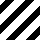
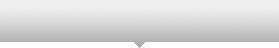
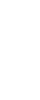
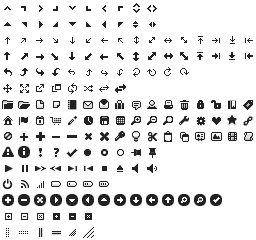
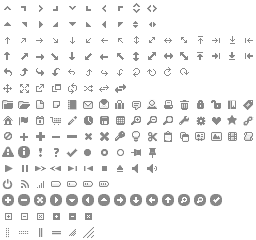
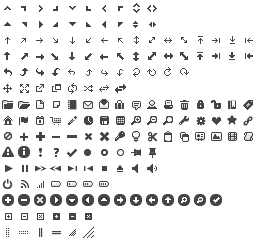
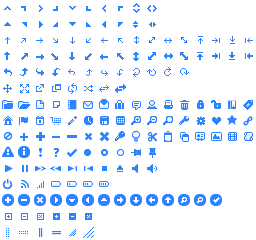
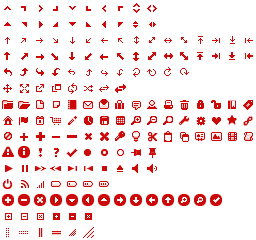
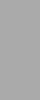
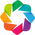
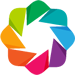
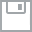
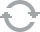
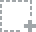
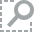
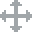
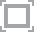
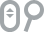

In [5]:
#this line must be in its own cell 
bp.output_notebook()

In [6]:
x = bp.figure(plot_width=900, plot_height=700, title="Map of StackOverflow Tags",
       tools="pan,wheel_zoom,reset,hover,previewsave", toolbar_location="left",
       x_axis_type=None, y_axis_type=None, min_border=1)
x.scatter(
    x = df.x.values, 
    y = df.y.values, 
    color=colormap[df.cluster.astype(int).values],
    alpha=0.6,
    radius=(df.numQuestions.values ** .4)/10,
    source=bp.ColumnDataSource({"tags": df.index.values})
).select(dict(type=HoverTool)).tooltips = {"tag":"@tags"}

labels = df.reset_index().groupby(['grid_x', 'grid_y'], as_index=False).first()
labels = labels[labels["numQuestions"] > 200]
x.text(
    x = labels.x.values, 
    y = labels.y.values,
    text = labels._rowName.values,
    text_align="center", text_baseline="middle",
    text_font_size="8pt", text_font_style="bold",
    text_color="#333333"
)
bp.show(x)

## Where to next?

Check out the other [Tutorials and Demos](/doc/#builtin/Demos.md.html).